# Classification of Smokers and Nonsmokers by Vital Signs

## Problem Statement
The aim of this project is to classify smokers and non-smokers by vital signs obtained from a 55k entry dataset collected by the Korean National Insurance Company.
### Why
Although the negative physical effects of smoking are well known, there are many reasons why a classification tool for identifying smokers. Though more research is needed, a tool like the one proposed in this project could help doctors flag potential smokers earlier, without the need for self identification which could improve patient outcomes. A tool like this could also be used to gather population level data about smokers, which could be used to target environment based interventions. 
## Summary
This project did not have the outcome that I had hoped for. The biggest contributing factor was that the data skewed heavily male (64% vs 34%), and there was a lack of sufficient data on female smokers (only 4% of the female data are smokers). With that said, the dataset turned out to be more about demographic information than vital signs. 
The highest accuracy reached was 77.22% using random forest. This almost reaches the benchmark success rate of 77.36% also using random forest.
## Reflection
If I were to do this project over again, I would control for age, and I would divide the group into male and female, to control for the numbers disparity. I would also explore more models.


### Comments

This was my first project. There were some techniques that I didn`t know how to use, so I borrowed my methods for finding highly correlated features and finding influential featuresfrom my [benchmark notebook](https://github.com/Sofxley/signal-of-smoking-classification). 



# EDA



# 1. Imports

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import BaggingClassifier

# Import metrics etc.
from sklearn.model_selection import GridSearchCV, learning_curve, StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from collections import OrderedDict
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import Perceptron
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import warnings


In [ ]:

SEED = 32

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# plot style
plt.style.use('Solarize_Light2')
mpl.rc('axes', labelweight='ultralight', titleweight='semibold', labelsize=10, )

In [ ]:
def description(data):
	'''
	Returns a dataframe with a detailed description of the data
	'''
	dtypes = data.dtypes
	counts = data.apply(lambda col: col.count())
	nulls = data.apply(lambda col: col.isnull().sum())
	uniques = data.apply(lambda col: col.unique())
	n_uniques = data.apply(lambda col: col.nunique())
	maxs = data.apply(lambda col: col.max())
	mins = data.apply(lambda col: col.min())

	cols = {'dtypes':dtypes, 'counts':counts, 'nulls' : nulls,
            'max':maxs, 'min':mins,'n_uniques':n_uniques, 'uniques':uniques}
	return pd.DataFrame(data=cols)


# 2. Loading the Data

In [6]:
smoking_ = pd.read_csv("smoking.csv", index_col='ID')

smoking = smoking_.copy()

In [7]:
smoking.T

ID,0,1,2,3,4,5,6,7,9,10,...,55655,55663,55666,55671,55673,55676,55681,55683,55684,55691
gender,F,F,M,M,F,M,M,M,F,M,...,M,M,M,M,F,F,F,F,M,M
age,40,40,55,40,40,30,40,45,50,45,...,20,40,40,40,60,40,45,55,60,55
height(cm),155,160,170,165,155,180,160,165,150,175,...,175,180,170,170,150,170,160,160,165,160
weight(kg),60,60,60,70,60,75,60,90,60,75,...,75,85,65,80,50,65,50,50,60,65
waist(cm),81.3,81.0,80.0,88.0,86.0,85.0,85.5,96.0,85.0,89.0,...,85.0,86.5,85.0,90.5,75.0,75.0,70.0,68.5,78.0,85.0
eyesight(left),1.2,0.8,0.8,1.5,1.0,1.2,1.0,1.2,0.7,1.0,...,0.9,1.2,1.2,1.2,1.0,0.9,1.2,1.0,0.8,0.9
eyesight(right),1.0,0.6,0.8,1.5,1.0,1.2,1.0,1.0,0.8,1.0,...,1.5,1.2,1.2,1.5,1.2,0.9,1.2,1.2,1.0,0.7
hearing(left),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
hearing(right),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
systolic,114.0,119.0,138.0,100.0,120.0,128.0,116.0,153.0,115.0,113.0,...,118.0,116.0,106.0,130.0,102.0,110.0,101.0,117.0,133.0,124.0


In [8]:
smoking = smoking.drop("oral", axis = 1)

I dropped oral because all the answers were "Y", so it did not add anything to the data.

In [9]:
# Change the column names to the more convinient ones. copied this from the benchmark notebook.
smoking.rename(columns={'height(cm)':'height', 'weight(kg)':'weight','waist(cm)':'waist',
                        'eyesight(left)':'eyesight_left', 'eyesight(right)':'eyesight_right',
                        'hearing(left)':'hearing_left', 'hearing(right)':'hearing_right',
                        'fasting blood sugar':'fasting_blood_sugar',  'Cholesterol':'cholesterol',
                        'HDL':'hdl','LDL':'ldl','Urine protein':'urine_protein',
                        'serum creatinine':'serum_creatinine', 'AST':'ast','ALT':'alt',
                        'Gtp':'gtp', 'dental caries' : 'dental_caries'}, inplace=True)

smoking.shape

(55692, 25)

In [10]:
smoking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55692 entries, 0 to 55691
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               55692 non-null  object 
 1   age                  55692 non-null  int64  
 2   height               55692 non-null  int64  
 3   weight               55692 non-null  int64  
 4   waist                55692 non-null  float64
 5   eyesight_left        55692 non-null  float64
 6   eyesight_right       55692 non-null  float64
 7   hearing_left         55692 non-null  float64
 8   hearing_right        55692 non-null  float64
 9   systolic             55692 non-null  float64
 10  relaxation           55692 non-null  float64
 11  fasting_blood_sugar  55692 non-null  float64
 12  cholesterol          55692 non-null  float64
 13  triglyceride         55692 non-null  float64
 14  hdl                  55692 non-null  float64
 15  ldl                  55692 non-null  floa

Useful function. Reveales that there are no missing values. It also yields clues as to continuous vs discreet data, and categorical data.

In [11]:
description(smoking)

,dtypes,counts,nulls,max,min,n_uniques,uniques
gender,object,55692,0,M,F,2,"[F, M]"
age,int64,55692,0,85,20,14,"[40, 55, 30, 45, 50, 35, 60, 25, 65, 20, 80, 7..."
height,int64,55692,0,190,130,13,"[155, 160, 170, 165, 180, 150, 175, 140, 185, ..."
weight,int64,55692,0,135,30,22,"[60, 70, 75, 90, 65, 45, 55, 50, 85, 80, 100, ..."
waist,float64,55692,0,129.0,51.0,566,"[81.3, 81.0, 80.0, 88.0, 86.0, 85.0, 85.5, 96...."
eyesight_left,float64,55692,0,9.9,0.1,19,"[1.2, 0.8, 1.5, 1.0, 0.7, 0.9, 0.3, 0.2, 0.1, ..."
eyesight_right,float64,55692,0,9.9,0.1,17,"[1.0, 0.6, 0.8, 1.5, 1.2, 0.7, 0.4, 0.9, 0.3, ..."
hearing_left,float64,55692,0,2.0,1.0,2,"[1.0, 2.0]"
hearing_right,float64,55692,0,2.0,1.0,2,"[1.0, 2.0]"
systolic,float64,55692,0,240.0,71.0,130,"[114.0, 119.0, 138.0, 100.0, 120.0, 128.0, 116..."


This reveals in addition to the target variable, there are 3 categorical variables: gender, dental_caries and tartar.
There are also 3 ordinal categorical variables: hearing_left, hearing_right and urine_protein.



# Encoding Gender And Tartar

In [12]:
for col in ['gender','tartar']:
	smoking[col] = LabelEncoder().fit_transform(smoking[col])

description(smoking)

,dtypes,counts,nulls,max,min,n_uniques,uniques
gender,int64,55692,0,1.0,0.0,2,"[0, 1]"
age,int64,55692,0,85.0,20.0,14,"[40, 55, 30, 45, 50, 35, 60, 25, 65, 20, 80, 7..."
height,int64,55692,0,190.0,130.0,13,"[155, 160, 170, 165, 180, 150, 175, 140, 185, ..."
weight,int64,55692,0,135.0,30.0,22,"[60, 70, 75, 90, 65, 45, 55, 50, 85, 80, 100, ..."
waist,float64,55692,0,129.0,51.0,566,"[81.3, 81.0, 80.0, 88.0, 86.0, 85.0, 85.5, 96...."
eyesight_left,float64,55692,0,9.9,0.1,19,"[1.2, 0.8, 1.5, 1.0, 0.7, 0.9, 0.3, 0.2, 0.1, ..."
eyesight_right,float64,55692,0,9.9,0.1,17,"[1.0, 0.6, 0.8, 1.5, 1.2, 0.7, 0.4, 0.9, 0.3, ..."
hearing_left,float64,55692,0,2.0,1.0,2,"[1.0, 2.0]"
hearing_right,float64,55692,0,2.0,1.0,2,"[1.0, 2.0]"
systolic,float64,55692,0,240.0,71.0,130,"[114.0, 119.0, 138.0, 100.0, 120.0, 128.0, 116..."


# 3. EDA

Text(0.5, 1.0, 'Correlation Plot')

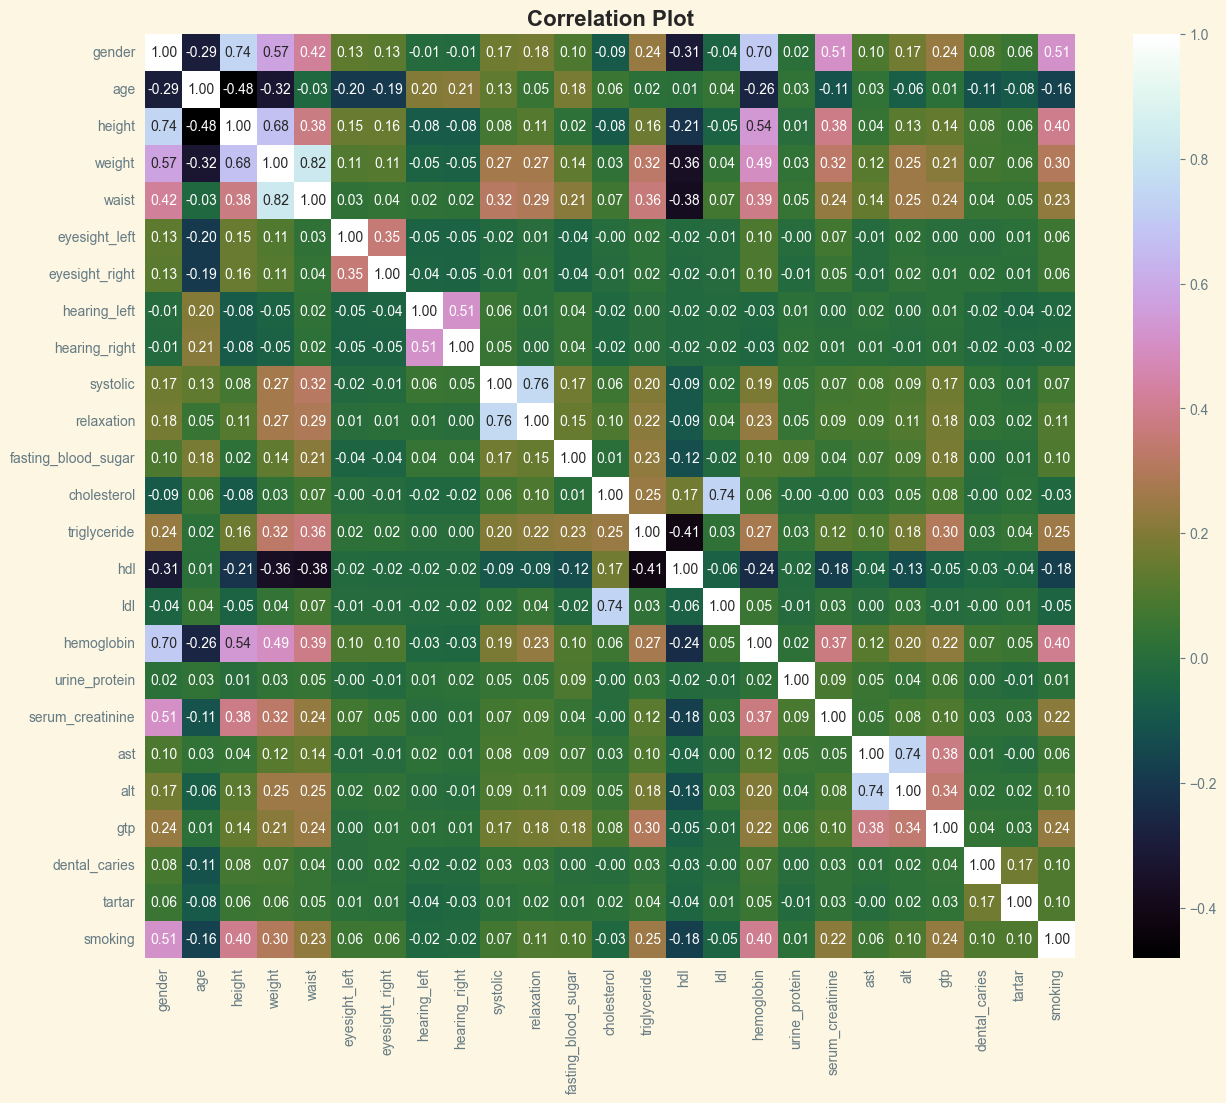

In [13]:
plt.figure(figsize=(15,12))

sns.heatmap(smoking.corr(), annot=True, cmap='cubehelix', fmt='.2f',)
plt.title('Correlation Plot')

## Correlation Summary

- **Gender**
  - Strongly correlated with:
    1. Height
    2. Hemoglobin
    3. Weight
    4. Serum Creatinine

- **Height**
  - Strongly correlated with:
    1. Gender
    2. Weight
    3. Hemoglobin

- **Weight**
  - Strongly correlated with:
    1. Waist circumference
    2. Height
    3. Gender

- **Other Notable Pairs**
  - **Systolic Blood Pressure** & **Diastolic (Relaxation) Blood Pressure**
  - **AST** & **ALT** (Liver Enzymes)
  - **LDL** & **Total Cholesterol**
  - **Hearing (Left)** & **Hearing (Right)**
  - **Eyesight (Left)** & **Eyesight (Right)**




We should note that gender and smoking have a high correlation at 0.51.

* We should expect high correlation between gender & hemoglobin and gender & serum creatine. This is backed up by common medical knowledge.
* None of the other correlations listed here are unexpected either.

# Segmented Analysis of Smoking And Gender

In [15]:
smokers= smoking.loc[smoking['smoking']==1]
non_smokers= smoking.loc[smoking['smoking']==0]


male = smoking.loc[smoking['gender']==1]
female = smoking.loc[smoking['gender']==0]

# there is an option to specify columns



Text(0.5, 1.0, 'Female Smoker Classification')

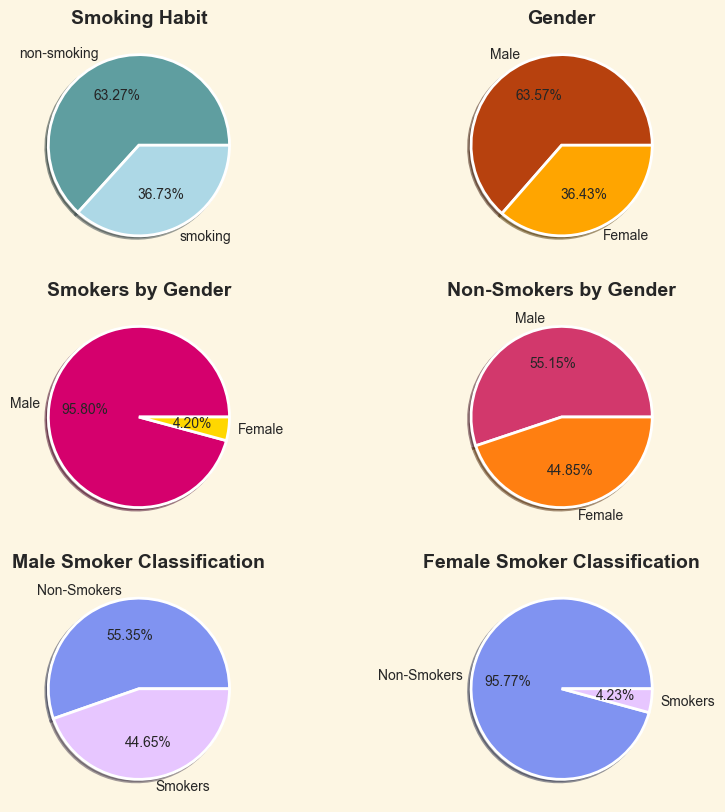

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(321)
plt.pie(smoking['smoking'].value_counts(), labels=['non-smoking', 'smoking'],
		autopct="%1.2f%%", colors=["#5F9EA0", "#ADD8E6"],
		wedgeprops=dict(width=1, edgecolor='w', linewidth=2), shadow=True, )
plt.title('Smoking Habit', fontsize=14)

plt.subplot(322)
plt.pie(smoking['gender'].value_counts(), labels=['Male','Female'],
		autopct="%1.2f%%", colors = ["#B7410E", "#FFA500"],
		wedgeprops=dict(width=1, edgecolor='white', linewidth=2), shadow=True, )
plt.title('Gender', fontsize=14, )

plt.subplot(323)

plt.pie(smokers['gender'].value_counts(), labels=['Male','Female'],
        autopct="%1.2f%%", colors = ["#D5006D", "#FFD700"],
        wedgeprops=dict(width=1, edgecolor='white', linewidth=2), shadow=True, )
plt.title('Smokers by Gender', fontsize=14, )


plt.subplot(324)
plt.pie(non_smokers['gender'].value_counts(), labels=['Male','Female'],
        autopct="%1.2f%%", colors = ["#D2386C", "#FF7F11"],
        wedgeprops=dict(width=1, edgecolor='white', linewidth=2), shadow=True, )
plt.title('Non-Smokers by Gender', fontsize=14, )

plt.subplot(325)
plt.pie(male['smoking'].value_counts(), labels=['Non-Smokers','Smokers'],
        autopct="%1.2f%%", colors=["#8093f1", "#e7c6ff"],
        wedgeprops=dict(width=1, edgecolor='white', linewidth=2), shadow=True, )
plt.title('Male Smoker Classification', fontsize=14, )

plt.subplot(326)
plt.pie(female['smoking'].value_counts(), labels=['Non-Smokers','Smokers'],
        autopct="%1.2f%%", colors=["#8093f1", "#e7c6ff"],
        wedgeprops=dict(width=1, edgecolor='white', linewidth=2), shadow=True, )
plt.title('Female Smoker Classification', fontsize=14, )


Our data is highly i

In [17]:
print(smoking['gender'].value_counts())

gender
1    35401
0    20291
Name: count, dtype: int64


At first, I was alarmed by the results of my segmentation analysis. Only 4.23% of females are smokers and they only make up 4.20% of the smoking population. This is a problem because our model could be influenced by this bias.

The easiest way to deal with this given my current capabilities would be to just change my problem definition slightly, to focus on the classification of male smokers by vital signs, since the male population is fairly balanced between smokers and non-smokers, and we have a large dataset. I may end up creating three models, one for male, female and the whole population since I have no idea how to deal with such a large bias.



## Age Breakdown



Text(0.5, 1.0, 'Distribution of Age,Smoking- Male')

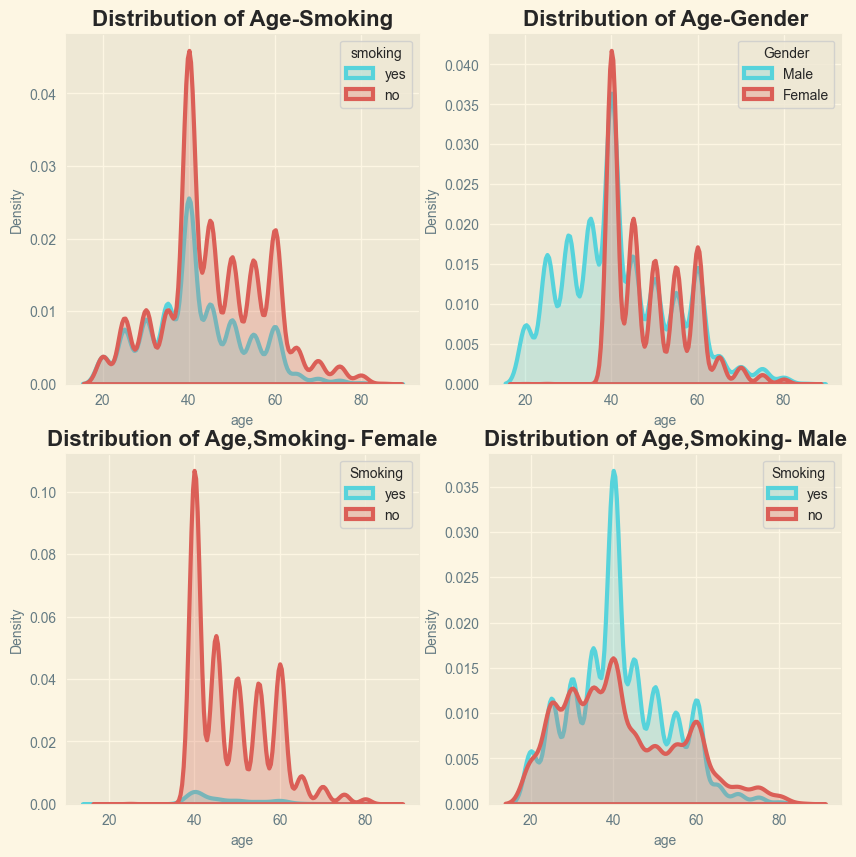

In [18]:
# Age w. respect to smoking status
# Age w. respect to gender
fig = plt.figure(figsize=(10,10))

plt.subplot(221)
sns.kdeplot(data=smoking, x='age', hue='smoking', palette='hls', linewidth=3, fill=True,)
plt.title('Distribution of Age-Smoking')
plt.legend(labels=['yes','no'], title='smoking')

plt.subplot(222)
sns.kdeplot(data=smoking, x='age', hue='gender', palette='hls', linewidth=3, fill=True,)
plt.title('Distribution of Age-Gender')
plt.legend(title='Gender', labels=['Male','Female'])

# women smoking, age
plt.subplot(223)
sns.kdeplot(data=female, x='age', hue='smoking', palette='hls', linewidth=3, fill=True,)
plt.legend(title='Smoking', labels=['yes','no'])
plt.title("Distribution of Age,Smoking- Female")

plt.subplot(224)
sns.kdeplot(data=male, x='age', hue='smoking', palette='hls', linewidth=3, fill=True,)
plt.legend(title='Smoking', labels=['yes','no'])
plt.title("Distribution of Age,Smoking- Male")
# men smoking, age

The age distribution for this study is fairly balanced for men, but shows a much older demographic for women. This could be a result of how the data was collected.

The study shows an average age for participants and smokers alike to be 40. The age demographic of the women could be a reason so few women reported smoking. It could be possible that cultural norms have shifted over the years towards less taboos towards women engaging in "vices".

It is likely that smoking is most common regardless of gender, among the age demographic of people around 40 years old.
 Perhaps these people were the right age when public knowledge around smoking was lax, and smoking was fashionable.

# Exploration of Continuous Variables by Age, Gender and Smoking Status

Here are some violin plots exploring a few continuous variables. I have them tested for age and gender on the right, and smoking and gender on the left.
I chose to do this since it was a clear middle aged demographic for smokers, and I wanted to check that the statistical signifficance could not be explained away by age.




In [20]:
cols = ['hemoglobin','weight','waist','serum_creatinine','ast','alt','ldl','cholesterol']

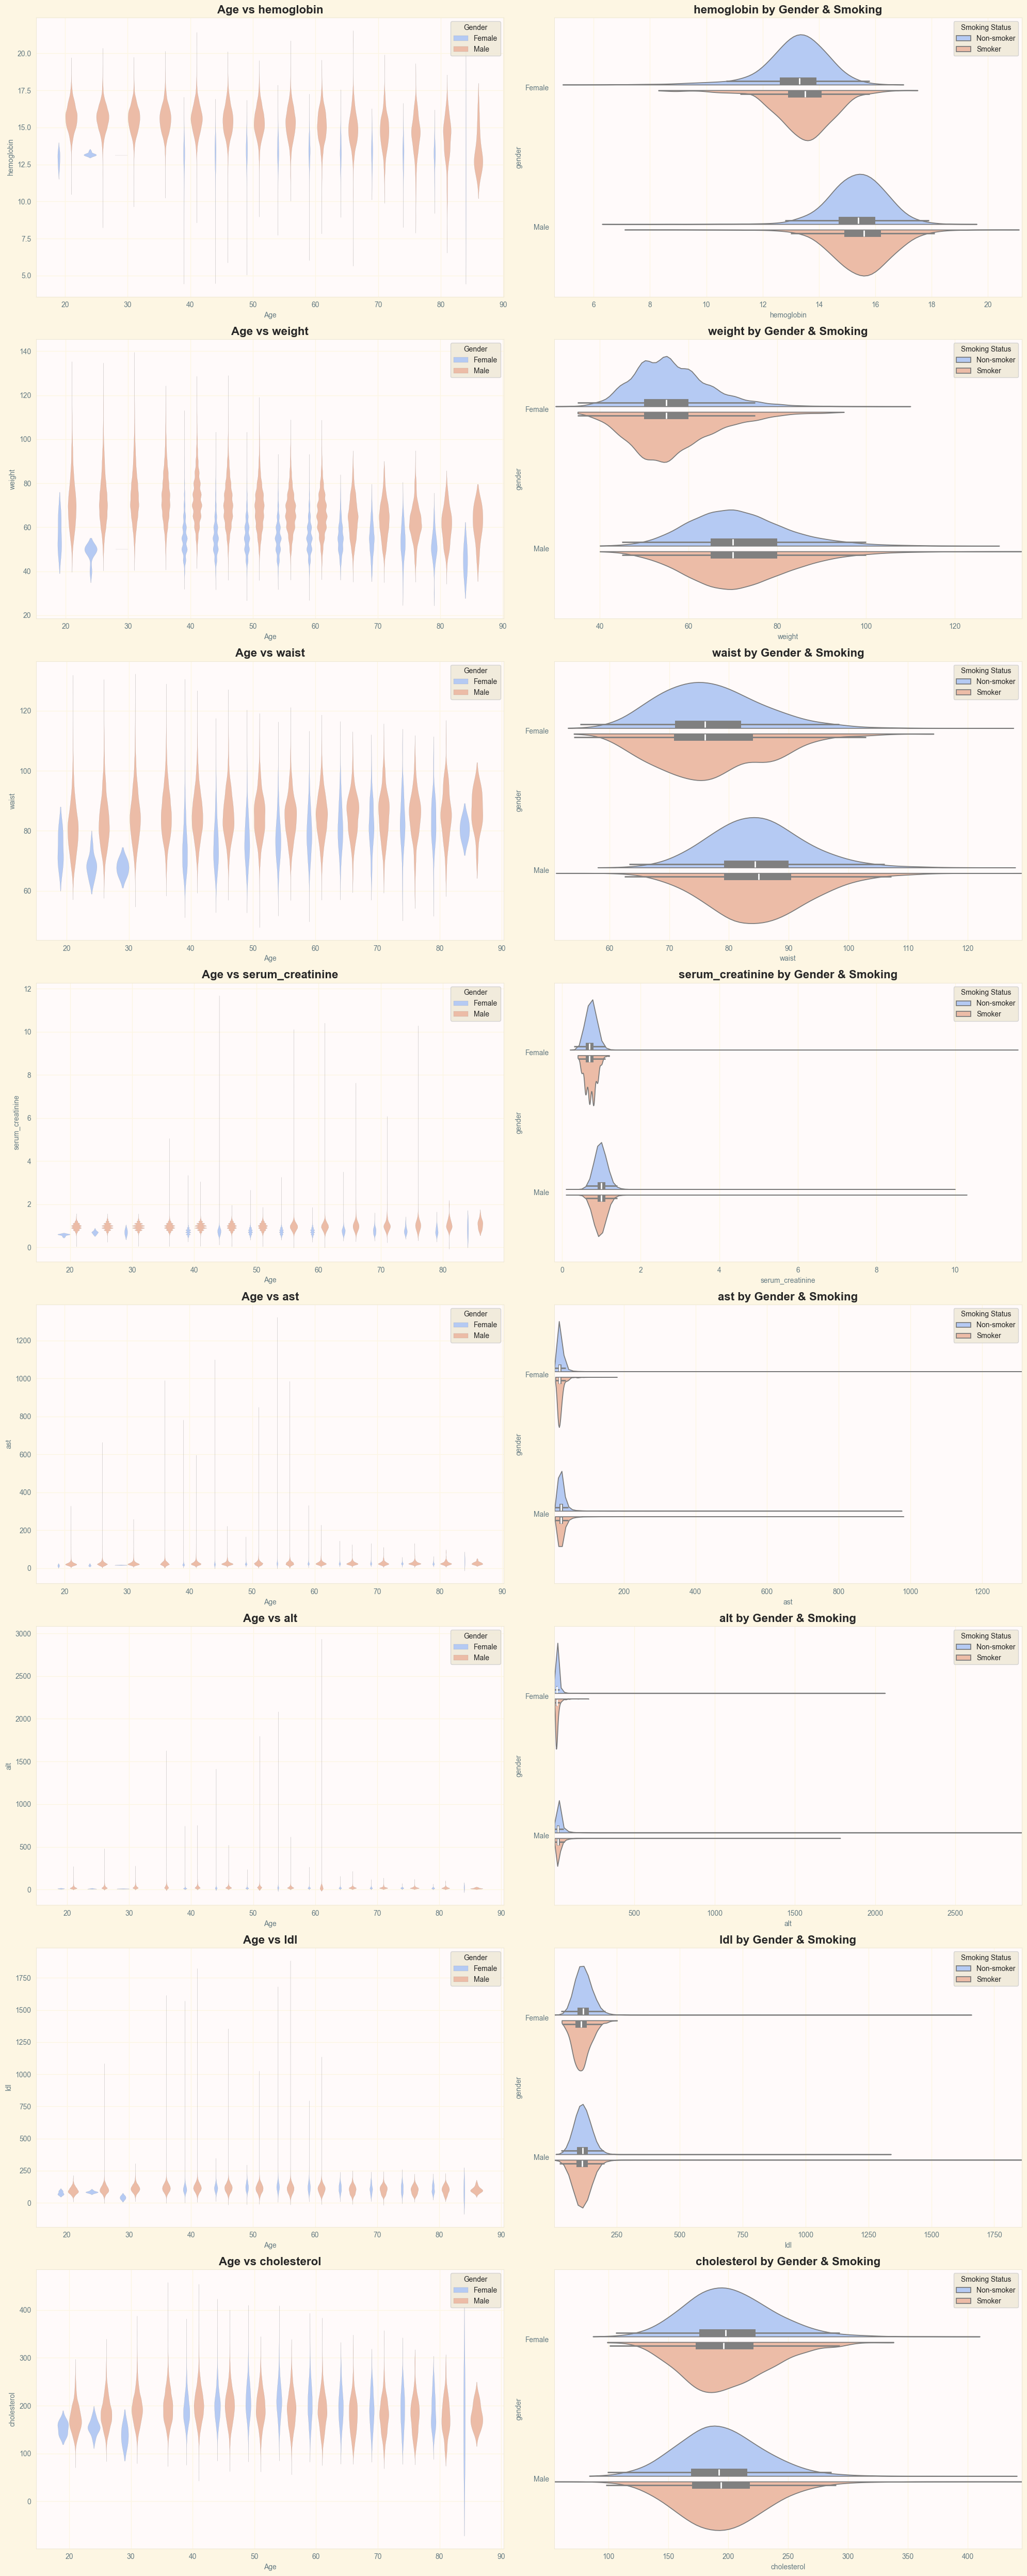

In [21]:
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(20,50))

for i, col in enumerate(cols):

    plt.subplot(len(cols), 2, i*2 + 1)
    sns.violinplot(
        data=smoking,
        x='age',
        y=col,
        hue='gender',
        split=False,
        native_scale=True,
        legend='full',
        palette='coolwarm',
        inner=None,
	    linewidth=0.1,
	    #linecolor='dark grey'

    )

    plt.title(f'Age vs {col}')
    plt.xlabel('Age')
    plt.ylabel(col)
    plt.legend(title='Gender', loc='best')

    handles, labels = plt.gca().get_legend_handles_labels()
    custom_labels = ['Female','Male']
    plt.legend(handles, custom_labels, title='Gender', loc='upper right')


    ax1 = plt.gca()
    ax1.set_facecolor("snow")


    plt.subplot(len(cols), 2, i*2 + 2)
    sns.violinplot(
        data=smoking,
        x=col,
        y='gender',
        hue='smoking',
        split=True,
        #inner="quart",
        inner_kws=dict(box_width=10, whis_width=2, color=".5"),
        gap = .1,
        orient='h',
        bw=0.25,
        cut=0,
        legend='full',
        palette='coolwarm'
    )
    plt.xlim(smoking[col].min() - 0.3, smoking[col].max() + 0.1)
    plt.title(f'{col} by Gender & Smoking')
    plt.yticks([0,1], ['Female','Male'])

    handles, labels = plt.gca().get_legend_handles_labels()
    custom_labels = ['Non-smoker', 'Smoker']  # Customize labels
    plt.legend(handles, custom_labels, title='Smoking Status', loc='upper right')

    ax2 = plt.gca()
    ax2.set_facecolor("snow")

plt.tight_layout()
plt.show()



**Results**

* Hemoglobin
    *   Noticeably higher for smokers than non-smokers. This could be statistically significant since the violin plots for age do not indicate an increase in hemoglobin for people in middle age.
    *   The right tail for smokers was also slightly fatter, indicating a greater distribution of higher hemoglobin.

* Weight and waist, though at first not much stood out, there was a similar pattern with the right tails being slightly thicker for non smokers, indicating smokers are more likely to be very heavy compared to non smokers, and more likely to have larger waists. This could be for other lifestyle reasons though, since smokers are more likely to have depression and more likely to be lower income.

* Serum Creatine had the same distribution for male smokers and non smokers. The serum creatine for women smokers had greater varience, though this could be due to small sample size.

* AST and ALT appeared unaffected

* It appears that female smokers have slightly less ldl, though this is likely due to other factors, since male smokers had about the same ldl as male non-smokers.

* There is a similar pattern on display with cholesterol, with male smokers having slightly elevated levels compared to male non-smokers, and female smokers having slightly lower levels.





# Boxplots of Features

Text(0.5, 1.0, 'Box Plot of Numerical Features')

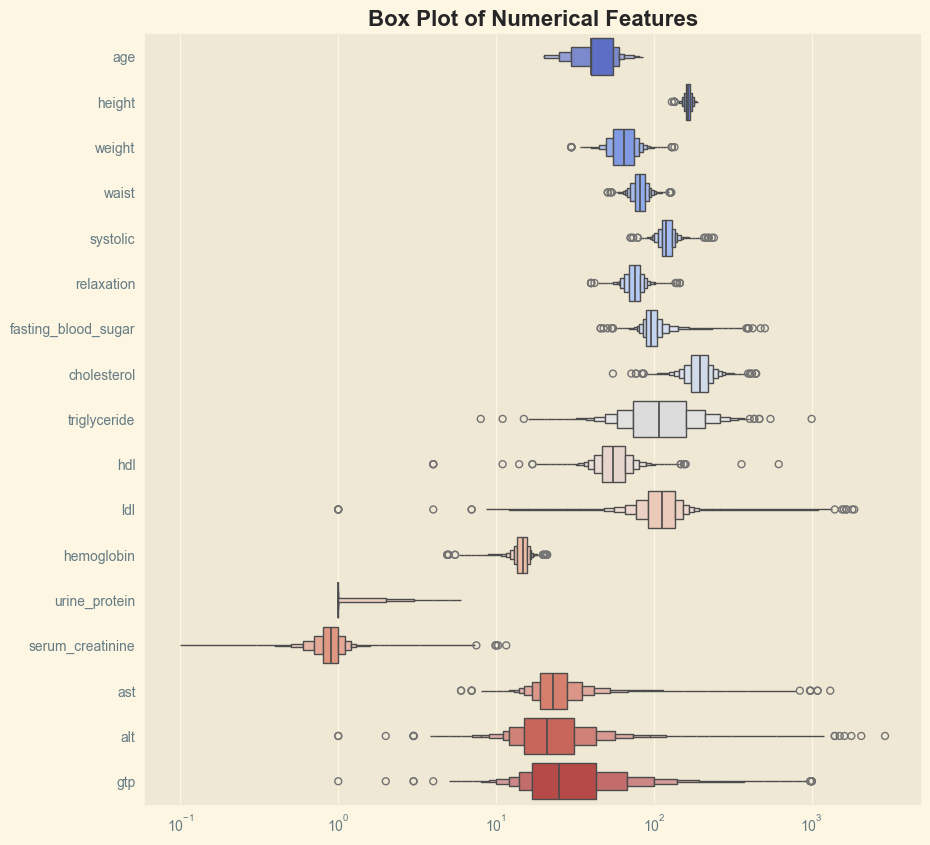

In [22]:
plt.figure(figsize=(10,10))

sns.boxenplot(data=smoking.drop(columns=['gender','dental_caries','hearing_left','hearing_right','eyesight_left','eyesight_right','tartar','smoking']), orient='h', palette='coolwarm')
plt.xscale('log')
plt.title('Box Plot of Numerical Features')

The boxplots show numerous outliars and that the data differs drastically in scale.
Random forest is a great algorithm candidate for these reasons along with the large sample size for our classification problem.

# Model
## Model Selection

Random forest relies on a bootstrap method for obtaining samples, that is it randomly selects data points with replacement.

Random forest is:
* Ideal for large samples
* Resistent to outliers
* Not sensitive to scale

We still have to deal with the fact that our dataset is highly unbalanced both between genders and smoking vs non-smoking. Sofexley uses stratified sampling, explaining that this is to ensure a roughly even number of smokers and non smokers in each sample. I am going to take their lead.

## Split Dataset

In [23]:
def split_dataset(X, y, test_size=0.2, valid_size=0.3, seed=SEED):
    '''
    Returns the training, validation, test set pairs generated by stratified splitting.
    '''
    # Train_val & test split
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    train_val_idx, test_idx = next(strat_split.split(X, y))

    X_train_val, y_train_val = X.iloc[train_val_idx], y.iloc[train_val_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Train and val split
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=valid_size, random_state=seed)
    train_idx, val_idx = next(strat_split.split(X_train_val, y_train_val))

    X_train, y_train = X_train_val.iloc[train_idx], y_train_val.iloc[train_idx]
    X_val, y_val = X_train_val.iloc[val_idx], y_train_val.iloc[val_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test


In [24]:
Smoking = smoking.reset_index().drop('ID', axis=1)

X = smoking.drop('smoking', axis = 1).copy()
y = pd.DataFrame(smoking['smoking'], index = smoking.index)

X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y, test_size=0.2,valid_size=0.3,seed=SEED)

y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(31187, 24) (31187,)
(13366, 24) (13366,)
(11139, 24) (11139,)


# Model

Sofexley removed outliars using isolation forest, which I didnt fully understand so I am not incorporating it.

I am however following these steps:
* Baseline model
* testing the baseline model:
    * with and without highly correlated features
    * feature importance: number of features
* Hyperparameter tuning

## Model Evaluation

I liked how Sofexley created functions for model evaluation. I thought it kept things nice and clean.

In [26]:
def model_evaluation(train, predict):
    print("\nClassification Report")
    print(classification_report(train, predict))

    print("Confusion Matrix training")
    cm = confusion_matrix(train, predict)

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()

## Baseline Model

In [27]:
model = RandomForestClassifier(n_estimators = 100, random_state = SEED)

model.fit(X_train,y_train)

y_pred_tr = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_te = model.predict(X_test)

Baseline Model-Training Dataset

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19732
           1       1.00      1.00      1.00     11455

    accuracy                           1.00     31187
   macro avg       1.00      1.00      1.00     31187
weighted avg       1.00      1.00      1.00     31187

Confusion Matrix training


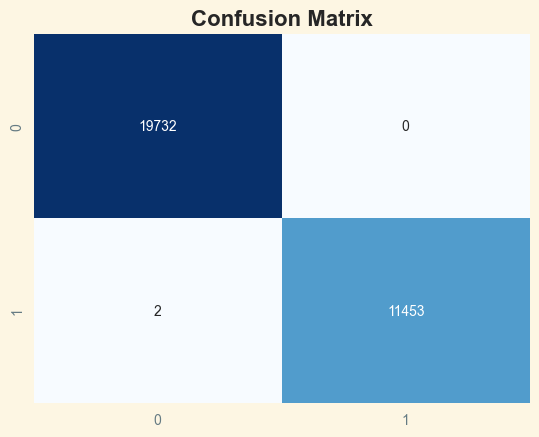

In [28]:
print("Baseline Model-Training Dataset")
model_evaluation(y_train,y_pred_tr)

Baseline Model-Training Dataset

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      8457
           1       0.74      0.76      0.75      4909

    accuracy                           0.81     13366
   macro avg       0.80      0.80      0.80     13366
weighted avg       0.81      0.81      0.81     13366

Confusion Matrix training


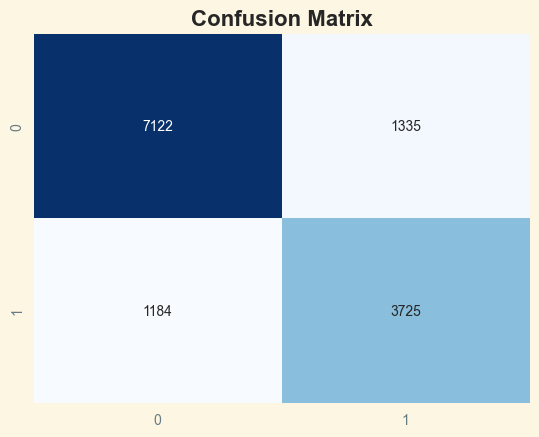

In [29]:
print("Baseline Model-Training Dataset")
model_evaluation(y_val,y_pred_val)

### Comments
As expected, the model is overfitting. We will see what happens as we explore.

## Highly Correlated Features

Text(0.5, 1.0, 'Positive Correlation Matrix')

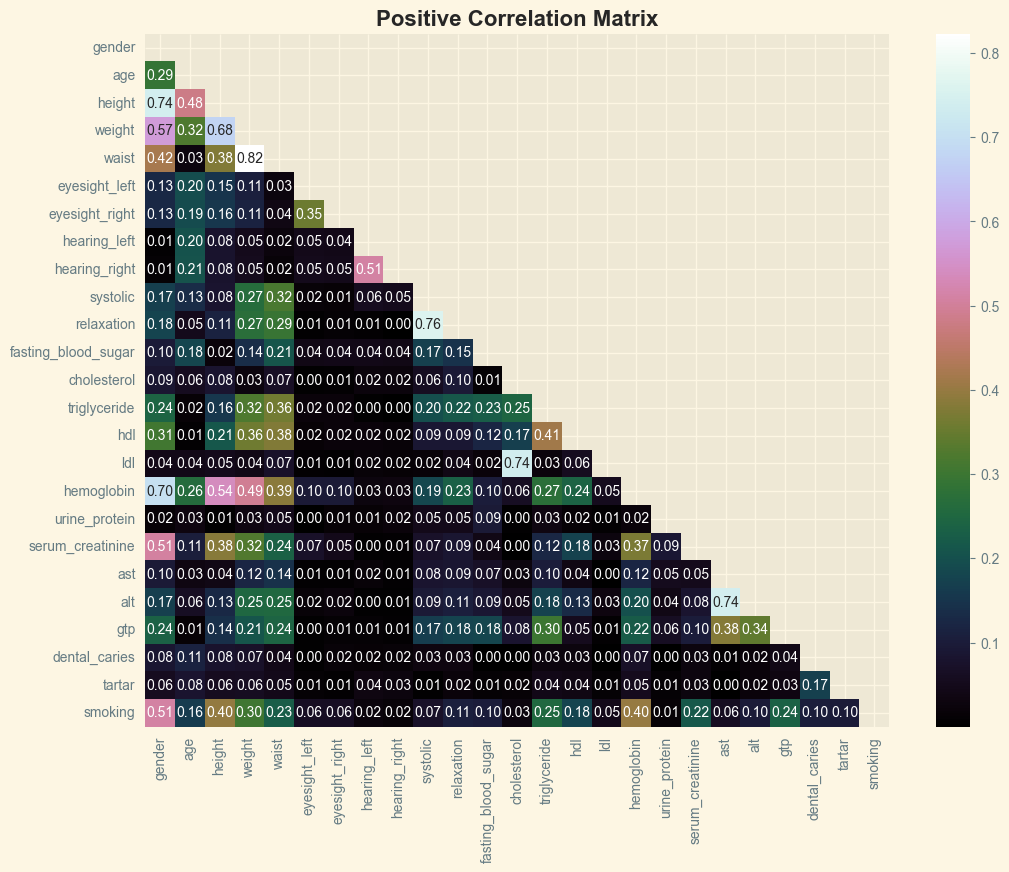

In [30]:
corr_df = smoking.corr().abs() # creates a df of all the correlations, as a positive value between 0 and 1
mask = np.triu(np.ones_like(corr_df, dtype=bool)) # creates a template that is the upper triangle of a matrix of ones
tri_df = corr_df.mask(mask) # apply the mask to the data frame

plt.figure(figsize=(12,9))
sns.heatmap(tri_df, annot=True, cmap='cubehelix', fmt='.2f',)
plt.title('Positive Correlation Matrix')

Training Eval Report
 with correlation threshold:0.5

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19732
           1       1.00      1.00      1.00     11455

    accuracy                           1.00     31187
   macro avg       1.00      1.00      1.00     31187
weighted avg       1.00      1.00      1.00     31187

Confusion Matrix training


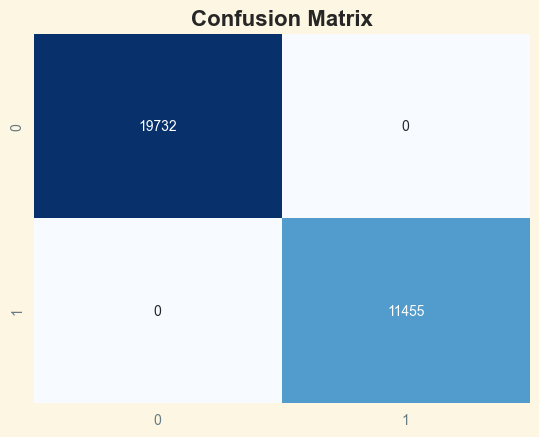

Validation Eval Report

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      8457
           1       0.74      0.69      0.71      4909

    accuracy                           0.80     13366
   macro avg       0.78      0.78      0.78     13366
weighted avg       0.80      0.80      0.80     13366

Confusion Matrix training


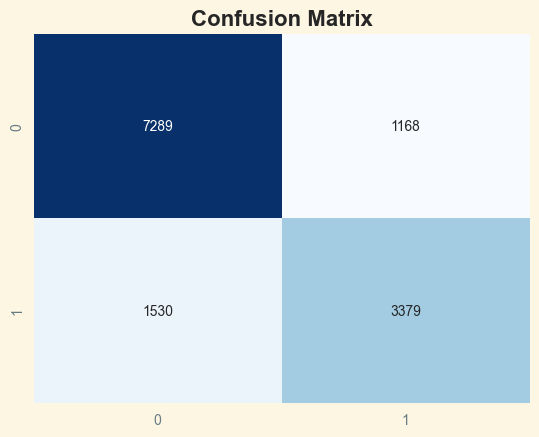

Training Eval Report
 with correlation threshold:0.6

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19732
           1       1.00      1.00      1.00     11455

    accuracy                           1.00     31187
   macro avg       1.00      1.00      1.00     31187
weighted avg       1.00      1.00      1.00     31187

Confusion Matrix training


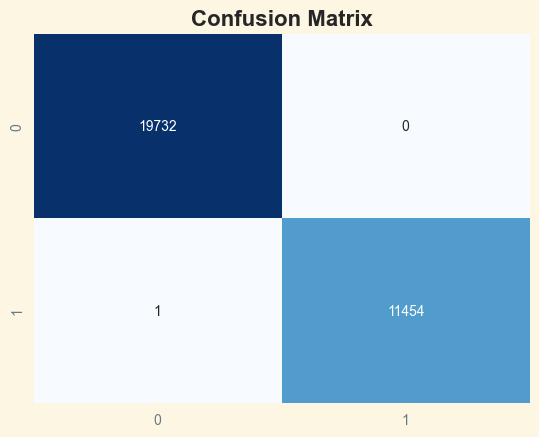

Validation Eval Report

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      8457
           1       0.74      0.69      0.72      4909

    accuracy                           0.80     13366
   macro avg       0.78      0.78      0.78     13366
weighted avg       0.80      0.80      0.80     13366

Confusion Matrix training


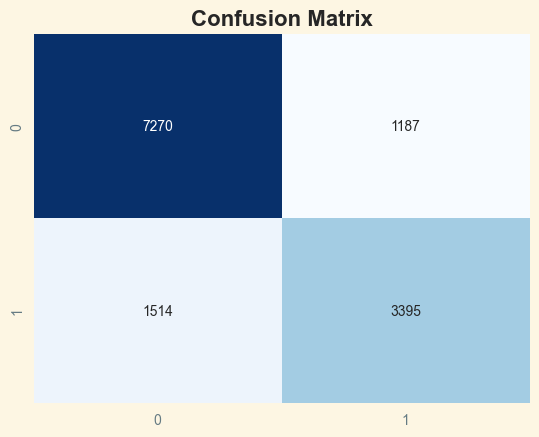

Training Eval Report
 with correlation threshold:0.7

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19732
           1       1.00      1.00      1.00     11455

    accuracy                           1.00     31187
   macro avg       1.00      1.00      1.00     31187
weighted avg       1.00      1.00      1.00     31187

Confusion Matrix training


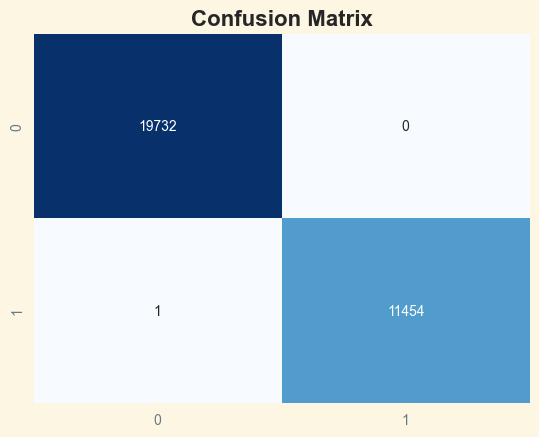

Validation Eval Report

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      8457
           1       0.74      0.72      0.73      4909

    accuracy                           0.81     13366
   macro avg       0.79      0.79      0.79     13366
weighted avg       0.80      0.81      0.81     13366

Confusion Matrix training


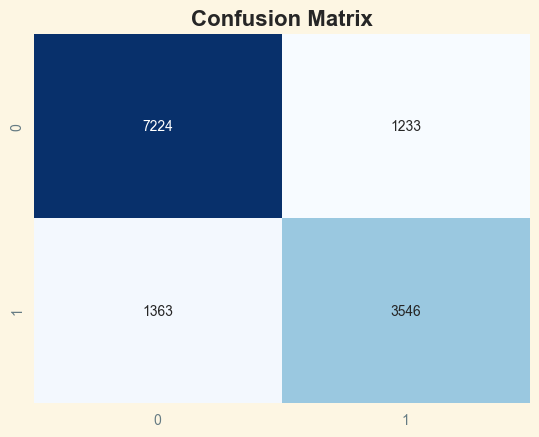

Training Eval Report
 with correlation threshold:0.75

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19732
           1       1.00      1.00      1.00     11455

    accuracy                           1.00     31187
   macro avg       1.00      1.00      1.00     31187
weighted avg       1.00      1.00      1.00     31187

Confusion Matrix training


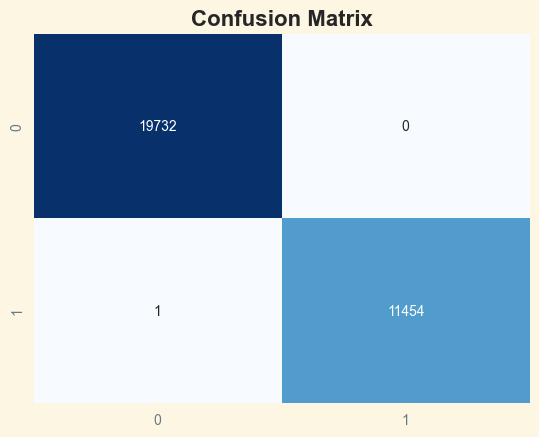

Validation Eval Report

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      8457
           1       0.74      0.76      0.75      4909

    accuracy                           0.81     13366
   macro avg       0.80      0.80      0.80     13366
weighted avg       0.81      0.81      0.81     13366

Confusion Matrix training


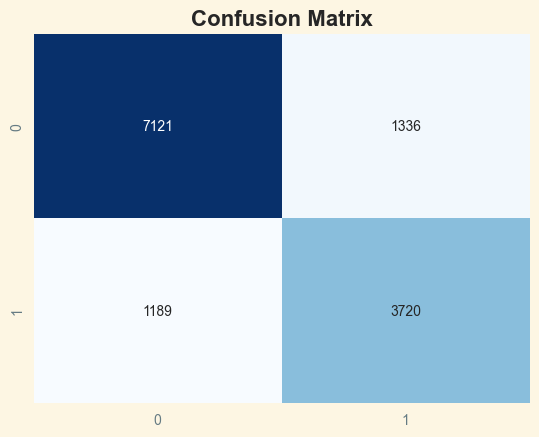

Training Eval Report
 with correlation threshold:0.85

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19732
           1       1.00      1.00      1.00     11455

    accuracy                           1.00     31187
   macro avg       1.00      1.00      1.00     31187
weighted avg       1.00      1.00      1.00     31187

Confusion Matrix training


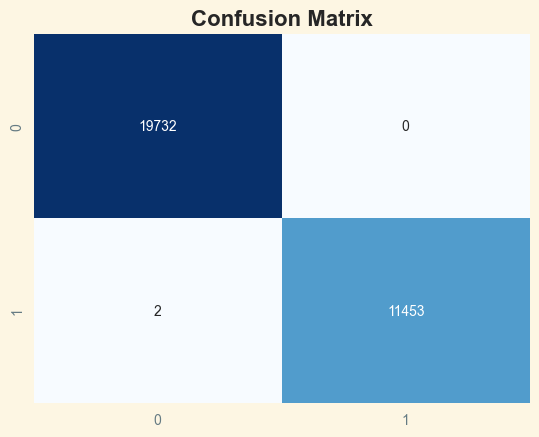

Validation Eval Report

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      8457
           1       0.74      0.76      0.75      4909

    accuracy                           0.81     13366
   macro avg       0.80      0.80      0.80     13366
weighted avg       0.81      0.81      0.81     13366

Confusion Matrix training


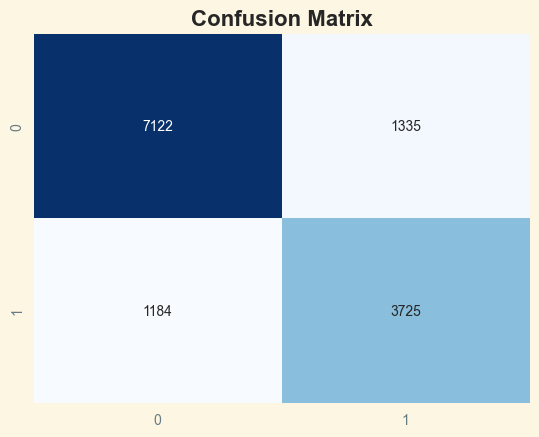

In [31]:
# Find the columns that meet threshold.
thresholds = [0.5,0.6,0.7,0.75,0.85]
results={}
for threshold in thresholds:
    high_corr_features = [col for col in tri_df.columns if any(tri_df[col] > threshold)]

    X_train_corr = X_train.drop(high_corr_features, axis=1)
    X_val_corr = X_val.drop(high_corr_features, axis=1)

    model_corr = RandomForestClassifier(n_estimators=100, random_state=SEED)
    model_corr.fit(X_train_corr, y_train)

# Predict
    y_pred_tr_corr = model_corr.predict(X_train_corr)
    y_pred_val_corr = model_corr.predict(X_val_corr)

    print(f"Training Eval Report\n with correlation threshold:{threshold}")
    model_evaluation(y_train, y_pred_tr_corr)

    print(f"Validation Eval Report")
    model_evaluation(y_val, y_pred_val_corr)




Since my model was still overfitting, I experimented with a few thresholds for correlation.
This was a dead end. The models all overfitted on training data, and none of the validation models did better than the baseline model.

# Exploring Feature Importance

Text(0.5, 0, 'Importance Score')

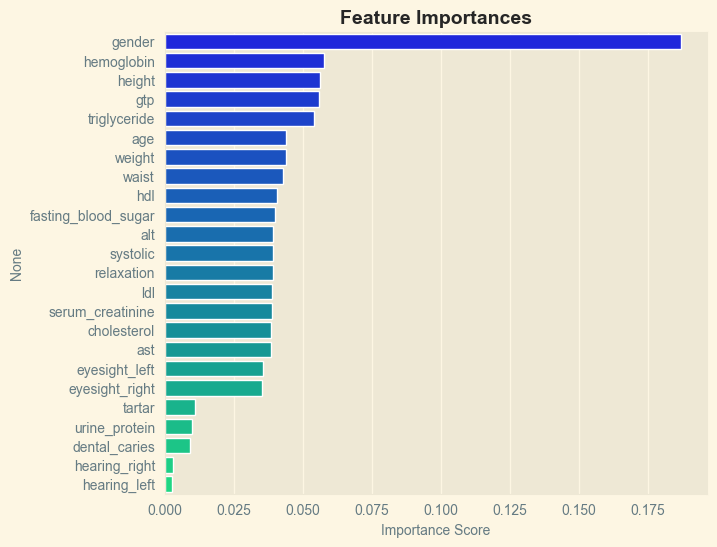

In [33]:
clf = ExtraTreesClassifier(n_estimators=1000, random_state=SEED)
clf.fit(X_train.values, y_train)
# Extract feature importances from the ET model and plot them.
imp_features = pd.Series(clf.feature_importances_,
                         index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(7, 6))
sns.barplot(x=imp_features, y=imp_features.index, palette='winter')
plt.title('Feature Importances', fontsize=14)
plt.xlabel('Importance Score')

Top 5 features:
* Gender
* Hemoglobin
* Height
* GTP
* Triglycerides

Gender and hemoglobin were expected as top contributers, as was height. I looked into GTP and smoking online, and could not find information. I could however find information that high triglyceride levels were related to smoking.

Though I did not expect urine protein or tartar to have a large impact on the model, I am surprised they have less of an impact than eyesight. For that matter, I am equally surprised eyesight has the impact that it does. I suspect this could be because smokers overall lead a less healthy lifestyle, which could impact their eyes, or some other unaccounted for demographic reason.

**Removed the model section.** After going back and trying several thresholds of correlation to drop in order to reduce complexity, I realized removing features was not helping.


# Model Hypertuning

In [48]:
param_grid = {
    'max_depth': [1, 5, 10, 20, 45],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8],
    'n_estimators': [10, 50, 100, 300, 500, 1000]
}
rf = RandomForestClassifier(random_state=SEED)

X_train_feat10 = X_train[imp_features.index[:10]]
X_val_feat10 = X_val[imp_features.index[:10]]

grid_search1 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search1.fit(X_val_feat10, y_val)

print("Best Parameters:", grid_search1.best_params_)
print("Best Cross-Validation Score:", grid_search1.best_score_)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best Parameters: {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1000}
Best Cross-Validation Score: 0.7638779551519516



Classification Report
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      7048
           1       0.67      0.71      0.69      4091

    accuracy                           0.77     11139
   macro avg       0.75      0.75      0.75     11139
weighted avg       0.77      0.77      0.77     11139

Confusion Matrix training


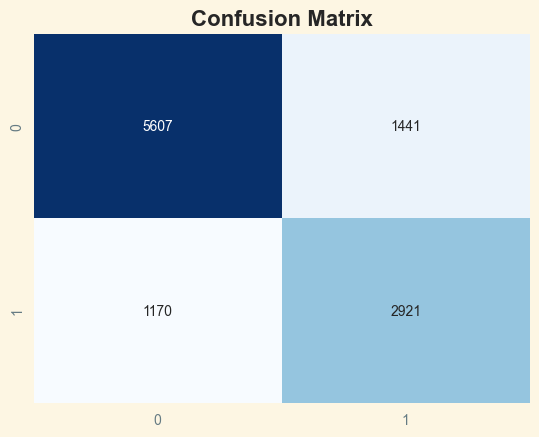

In [56]:
best_model = grid_search1.best_estimator_
y_test_pred_best=best_model.predict(X_test[imp_features.index[:10]])
model_evaluation(y_test,y_test_pred_best)

In [43]:
param_grid = {
    'max_depth': [1, 5, 10, 20, 45],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8],
    'n_estimators': [10, 50, 100, 300, 500, 1000]
}
rf = RandomForestClassifier(random_state=SEED)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best Parameters: {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 500}
Best Cross-Validation Score: 0.7753254028414005



Classification Report
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      7048
           1       0.69      0.74      0.71      4091

    accuracy                           0.78     11139
   macro avg       0.76      0.77      0.77     11139
weighted avg       0.78      0.78      0.78     11139

Confusion Matrix training


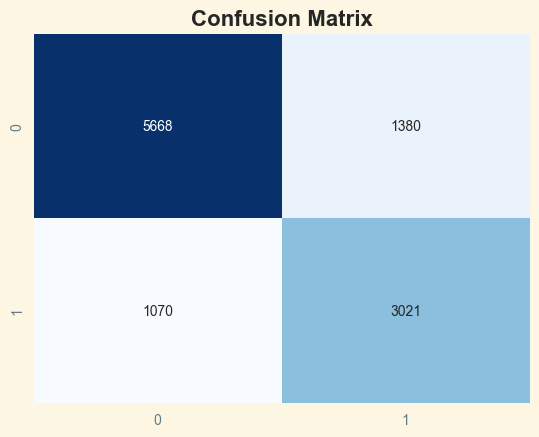

In [58]:
best_model2 = grid_search.best_estimator_
y_test_pred_best=best_model2.predict(X_test)
model_evaluation(y_test,y_test_pred_best)

In [60]:
print(f" Accuracy of best fit model all features:{cross_val_score(best_model2, X_test,y_test, cv=cv, scoring='accuracy').mean().round(4)*100}")

print(f" Accuracy of best fit model top 10 features:{cross_val_score(best_model, X_test,y_test, cv=cv, scoring='accuracy').mean().round(4)*100}")


 Accuracy of best fit model all features:77.22
 Accuracy of best fit model top 10 features:76.99000000000001
